In [ ]:
# Fig5 figure related scripts

In [3]:
BiocManager::install('data.tree')
BiocManager::install('FSelectorRcpp')
BiocManager::install('networkD3')

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://packagemanager.rstudio.com/all/__linux__/jammy/latest

Bioconductor version 3.16 (BiocManager 1.30.22), R 4.2.3 (2023-03-15)

Installing package(s) 'networkD3'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'boot', 'brew', 'circlize', 'cluster', 'codetools',
  'credentials', 'crul', 'dials', 'DiceDesign', 'e1071', 'forecast', 'foreign',
  'fracdiff', 'gert', 'ggpubr', 'ggrepel', 'ggsci', 'gh', 'glmnet', 'hardhat',
  'httr2', 'infer', 'lattice', 'lava', 'maps', 'MASS', 'mgcv', 'modeldata',
  'nlme', 'parsnip', 'pbdZMQ', 'pkgdown', 'pROC', 'prodlim', 'quantmod',
  'RCurl', 'recipes', 'remotes', 'repr', 'RODBC', 'roxygen2', 'rpart',
  'rsample', 'RSQLite', 'Seurat', 'slider', 'survival', 'tidymodels',
  'timeDate', 'tseries', 'TTR', 'tune', 'usethis', 'viridis', 'warp'

In [4]:
library(Seurat)
library(ggplot2)
library(scales)
library(stringr)
library(RColorBrewer)
library(repr)
library(doParallel)
library("viridis")  
library(patchwork)
library(ggsci)
source("./common_lineage_functions.r")
#need to write new functions to calculate the information gain of the normal version to avoid potential critics
library(tidyverse)
library(ggsignif)

library(FSelectorRcpp) #use information_gain function from published packages
library(Seurat)


Attaching package: ‘networkD3’


The following object is masked from ‘package:SeuratObject’:

    JS


The following object is masked from ‘package:Seurat’:

    JS


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
EBmerge = readRDS("../data/EBcombined.rds")

In [6]:
EBmerge@meta.data$cellBC = rownames(EBmerge@meta.data)
EBmerge@meta.data = EBmerge@meta.data %>% select(orig.ident, nCount_RNA,
                                                nFeature_RNA, S.Score, G2M.Score,
                                                Phase, cell_type, cellBC)

In [7]:
#colors
#color: similar cell type with similar colors, different cell type with different colors
cell_type = c('Heart','Neuron', 'Gut','Blood', 'CPM','PGC-like','Endothelium')
#colors = pal_d3()(7) #use the d3 series color

colors = c('#1F77B4FF','#FF7F0EFF','#2CA02CFF','#D62728FF','#9467BDFF','#8C564BFF','#E377C2FF')
cl_cols = setNames(colors, cell_type)

# checking individual datasets

In [8]:
#preprocess
#read the allele_table and related parameters
amplicon = "D8b"
singlecell=EBmerge@meta.data
cpf1_mutated=TRUE 
cas9_mutated=TRUE
cpf1_first=FALSE
remove_single_type=FALSE
filename1 = paste0('../data/EBallele_table/', amplicon, 'allCassiopeiaAllele.csv')
allele_table = read.csv(filename1, row.names=1)
##preprocessing
#both lineage and cell type information
LinTrans = allele_to_lineage(allele_table, singlecell)
#preprocessing, default, keep only muatated cas9 and cpf1 scars only
LinTrans = lintrans_preprocess(LinTrans, cpf1_mutated, cas9_mutated)

#obtatin the final dataframe for information gain calculation
linIG = lintrans_to_linig(LinTrans, cl_cols,cpf1_first, remove_single_type)
linIGx = linIG[,-1]

In [9]:
head(linIG)

cellBC,grp,cpf1,cas9,cell_type
<chr>,<chr>,<chr>,<chr>,<chr>
CELL1451_N1_3,grp10,grp10|-140:45Dl-140:45D,grp10|-140:45D,Heart
CELL1502_N1_3,grp10,grp10|-140:45Dl-140:45D,grp10|-140:45D,Heart
CELL2819_N1_3,grp11,grp11|-175:8Dl-150:3D,grp11|-175:8D,Heart
CELL919_N2_3,grp11,grp11|-175:8Dl-150:3D,grp11|-175:8D,Heart
CELL2931_N1_3,grp12,grp12|-178:18Dl-91:3D,grp12|-178:18D,Heart
CELL736_N2_3,grp12,grp12|-181:6Dl-91:3D,grp12|-181:6D,Heart


In [10]:
#NOTE: this itracer_plot function generate the iTracer plot without specifying mutated/non-mutated cells
#so this function have been replaced by function iTracer_full_plot                        
#optional check the iTracer plot, this itracer plot is related to information gain calculation
#waiting for further improvement
#linIG dataframe from EBlineages_3rd_zhum.ipynb
itracer_plot = function(amplicon_name,linIG,cl_cols, cpf1_first) {
    cl_orders = names(cl_cols)
    #linIG <- linIG[base::order(linIG$grp, linIG$cpf1,  linIG$cas9, setNames(1:length(cl_orders),cl_orders)[as.character(linIG$cell_type)]),]
    if (cpf1_first==TRUE) {
        linIG$pathString <- paste(amplicon_name,  linIG$grp, linIG$cpf1,linIG$cas9,linIG$cellBC, sep = "/")
        } else {
        linIG$pathString <- paste(amplicon_name,  linIG$grp, linIG$cas9, linIG$cpf1,linIG$cellBC, sep = "/")
    }
    linIG = as.data.frame(linIG)
    rownames(linIG) = linIG$cellBC
    lineage_cells <- as.Node(linIG)
    lineage_cells_network <- ToDataFrameNetwork(lineage_cells, "name")
    lineage_cells_list <- ToListExplicit(lineage_cells, unname = TRUE)
    cols <- c("#303030", cl_cols[as.character(linIG[lineage_cells_network[,3],"cell_type"])])
    cols[is.na(cols)] <- "#636363"
    jsarray <- paste0('["', paste(cols, collapse = '", "'), '"]')
    nodeStrokeJS <- JS(paste0('function(d, i) { return ', jsarray, '[i]; }'))
    itracerplot = radialNetwork(lineage_cells_list,  nodeColour = nodeStrokeJS, nodeStroke = NA, fontSize = 0)
    filename = paste0("../results/Fig5_",amplicon_name, "_iTracer_plot.html")
    saveNetwork(itracerplot,file=filename, selfcontained=T)
}
amplicon_name = 'D8b'
cpf1_first = FALSE
itracer_plot(amplicon_name, linIG, cl_cols, cpf1_first)

In [11]:
#remove cell information and reorder the columns to the actual gene editing orders
linIGx = linIGx[, c("grp","cas9","cpf1","cell_type")]
head(linIGx)

grp,cas9,cpf1,cell_type
<chr>,<chr>,<chr>,<chr>
grp10,grp10|-140:45D,grp10|-140:45Dl-140:45D,Heart
grp10,grp10|-140:45D,grp10|-140:45Dl-140:45D,Heart
grp11,grp11|-175:8D,grp11|-175:8Dl-150:3D,Heart
grp11,grp11|-175:8D,grp11|-175:8Dl-150:3D,Heart
grp12,grp12|-178:18D,grp12|-178:18Dl-91:3D,Heart
grp12,grp12|-181:6D,grp12|-181:6Dl-91:3D,Heart


In [12]:
#Note: When trying to define a function, do not include file input output operation, do not include visualization
#Not checking individual cell types, could also check individual cell types

#Note: information_gain calculate from FSelectorRcpp package use nat as basic unit, should transform into bit as unit
#information gain calculate the explained cell type shannon, which is equivalent the explained cell differentiation
#check the information gain change for each clone, each level
#define a function to obtain both information gain and cell type information gain ratio

ig_grp_within_sample = function(linIGx) {
    linGrps_split = split(linIGx, list(linIGx$grp))
    linGrps_igs = do.call(rbind, lapply(linGrps_split, function(linGrp) {
        ig = information_gain(formula = cell_type ~ ., linGrp[,-1]) #remove grp column
        ig$importance = (log2(exp(1)))*(ig$importance)
        ig$linGrp = linGrp$grp[1]
        celltype_entropy <- sum(-prop.table(table(linGrp[,"cell_type"])) * log2(prop.table(table(linGrp[,"cell_type"])))) 
        if (celltype_entropy>0) {
            ig$celltype_ratio = ig$importance/celltype_entropy
        } else {
            ig$celltype_ratio = 0
        }
        return(ig)
} ))
    return(linGrps_igs)
}


In [13]:
linGrps_igs = ig_grp_within_sample(linIGx)
head(linGrps_igs)

,attributes,importance,linGrp,celltype_ratio
,<chr>,<dbl>,<chr>,<dbl>
grp10.1,cas9,0,grp10,0
grp10.2,cpf1,0,grp10,0
grp11.1,cas9,0,grp11,0
grp11.2,cpf1,0,grp11,0
grp12.1,cas9,0,grp12,0
grp12.2,cpf1,0,grp12,0


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


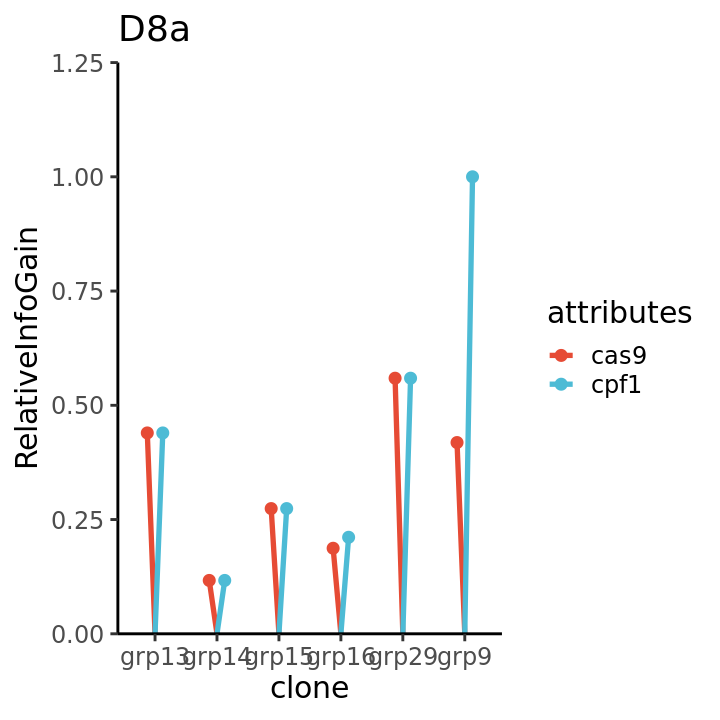

In [14]:
selected_linGrps_igs = linGrps_igs %>% filter(importance>0)
options(repr.plot.width=6, repr.plot.height=6)
ggplot(selected_linGrps_igs, aes(x = linGrp, y = celltype_ratio, color = attributes)) +
  geom_point(size = 3,position = position_dodge(width = 0.5)) +
  #theme(text = element_text(size = 18))+
  geom_segment(aes(xend = linGrp, yend = 0), size = 1.5,position = position_dodge(width = 0.5)) +
  theme_classic(base_size=18)+scale_y_continuous(expand=c(0,0),, limits=c(0, 1.25))+
  labs(x="clone",y='RelativeInfoGain')+
  scale_color_npg()+ggtitle("D8a")
ggsave("../results/Fig5_D8b_cas9cpf1mut_group_selection_by_selected_ig.pdf", width=6, height=6)

# checking all datasets

In [15]:
amplicons = c("D8a","D10a","D8b","D10b","D12","D14")

#NOTE: the barcode entropy here are level-wise, instead of calculate independently
#NOTE: currently, we only calculate the barcodeset instead of calculate individual barcodesets
#be careful with the column name order

#data filtering requirement
singlecell=EBmerge@meta.data
cpf1_mutated=TRUE 
cas9_mutated=TRUE
cpf1_first=FALSE #change the order of mutation events
#cpf1_first=TRUE
remove_single_type=FALSE

igs = data.frame(attributes=character(), importance=double(),celltype_ratio=double(), BC_ratio=double(),
                BCentropy=double(),sample=character())

for (amplicon in amplicons) {
    # allele datasets were obtained from Miaozhu and renamed
    filename1 = paste0('../data/EBallele_table/', amplicon, 'allCassiopeiaAllele.csv')
    allele_table = read.csv(filename1, row.names=1)
    ##preprocessing
    #both lineage and cell type information
    LinTrans = allele_to_lineage(allele_table, singlecell)
    #preprocessing, default, keep only muatated cas9 and cpf1 scars only
    LinTrans = lintrans_preprocess(LinTrans, cpf1_mutated, cas9_mutated)

    #obtatin the final dataframe for information gain calculation
    linIG = lintrans_to_linig(LinTrans, cl_cols,cpf1_first, remove_single_type)
    linIG = linIG[,-1]
    ig = information_gain(formula = cell_type ~ ., linIG)
    ig1 = information_gain(formula = cell_type ~ ., linIG, type='gainratio')
    ig$importance = (log2(exp(1)))*(ig$importance)
    celltype_entropy <- sum(-prop.table(table(linIG[,"cell_type"])) * log2(prop.table(table(linIG[,"cell_type"]))))

    if (celltype_entropy>0) {
        ig$celltype_ratio = ig$importance/celltype_entropy #normalized by celltype entropy
    } else {
        ig$celltype_ratio = 0
    }
    ig$BC_ratio = ig1$importance #gain ratio of barcodes,normalized by barcode entropy

    grpBCentropy =  sum(-prop.table(table(linIG[,"grp"])) * log2(prop.table(table(linIG[,"grp"])))) #actually all barcode combinations
    cas9BCentropy =  sum(-prop.table(table(linIG[,"cas9"])) * log2(prop.table(table(linIG[,"cas9"]))))
    cpf1BCentropy =  sum(-prop.table(table(linIG[,"cpf1"])) * log2(prop.table(table(linIG[,"cpf1"]))))
    ig$BCentropy = c(grpBCentropy, cpf1BCentropy, cas9BCentropy)

    ig$sample = amplicon
    igs = rbind(igs, ig)
}
colnames(igs) = c("bc_type", "information_gain", "normalized_ig", "normalizedBCig", "BCentropy","samples")
igs$samples = factor(igs$samples, levels=c("D8a","D10a","D8b","D10b","D12","D14"))
igs$bc_type = factor(igs$bc_type, levels=c("grp","cas9","cpf1"))
#igs$bc_type = factor(igs$bc_type, levels=c("grp","cpf1","cas9"))

In [16]:
igs

bc_type,information_gain,normalized_ig,normalizedBCig,BCentropy,samples
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
grp,0.74439075,0.4473586,0.17200076,4.327834,D8a
cpf1,1.37086519,0.8238528,0.23363635,5.867517,D8a
cas9,1.22262214,0.7347627,0.22342230,5.472248,D8a
grp,0.81357994,0.4821157,0.20214158,4.024802,D10a
cpf1,1.41346008,0.8375960,0.24275320,5.822622,D10a
cas9,1.37333815,0.8138203,0.24437056,5.619900,D10a
grp,0.40183805,0.2932726,0.13063018,3.076150,D8b
cpf1,0.76212625,0.5562210,0.17933417,4.249755,D8b
cas9,0.70116077,0.5117267,0.17236019,4.067997,D8b


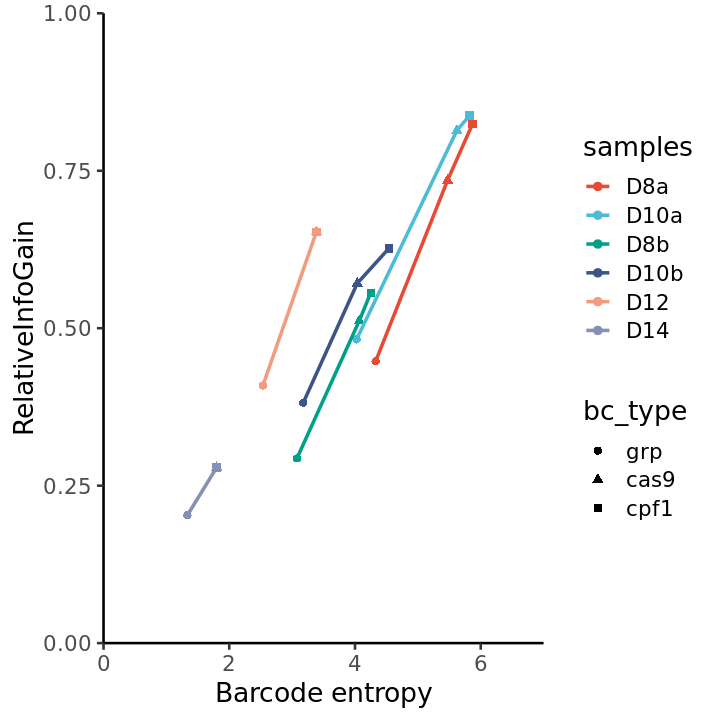

In [17]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(igs, aes(x=BCentropy,y=normalized_ig))+
    geom_point(aes(color=samples,fill=samples,shape=bc_type), size=2)+
    geom_line(aes(group=samples, color=samples), "stat"="identity", size=1)+
    theme_classic(base_size = 16)+scale_color_npg()+scale_fill_npg()+
    #geom_signif(comparisons = compaired, size=0.75, y_position = c(4.8), test = 't.test')+
    labs(x="Barcode entropy",y='RelativeInfoGain')+scale_y_continuous(expand=c(0,0), limits=c(0, 1.0))+
    scale_x_continuous(expand=c(0,0),limits=c(0,7))
ggsave("../results/Fig5_allsamples_cas9cpf1mut_BCig_relationship.pdf", width=6, height=6)

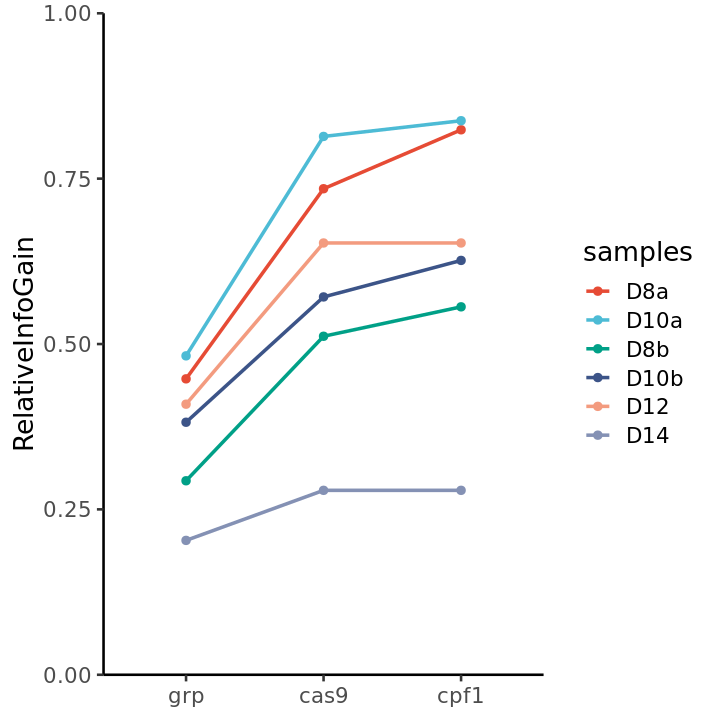

In [18]:
#visualize the relative information gain change according to different samples
options(repr.plot.width=6, repr.plot.height=6)

ggplot(igs, aes(x=bc_type,y=normalized_ig))+
    geom_point(aes(color=samples,fill=samples), size=2)+
    geom_line(aes(group=samples, color=samples), "stat"="identity", size=1)+
    theme_classic(base_size = 16)+
    scale_color_npg()+scale_fill_npg()+
    #labs(x=NULL,y='Relative information gain')+
    labs(x=NULL,y='RelativeInfoGain')+
    scale_y_continuous(expand=c(0,0), limits=c(0, 1))
ggsave("../results/Fig5_allsamples_cas9cpf1mut_ig_contribution.pdf", width=6, height=6)

In [19]:
#a paired t-test is required to demonstrate differentiation events are mainly occurred in the cas9 differentation stages
#normalized_ig is differentiation ig
igs_wide = igs %>% select(samples, bc_type, normalized_ig) %>% group_by(samples) %>% pivot_wider(names_from = bc_type, values_from=normalized_ig)
igs_wide$grp_cas9 = igs_wide$cas9-igs_wide$grp
igs_wide$cas9_cpf1 = igs_wide$cpf1-igs_wide$cas9
#pvalue less than 0.05, the data will be considered not fit into normal distribution
shapiro.test(append(igs_wide$grp_cas9, igs_wide$cas9_cpf1))

#paired statistic test
wilcox.test(igs_wide$grp_cas9, igs_wide$cas9_cpf1, paired=TRUE)
t.test(igs_wide$grp_cas9, igs_wide$cas9_cpf1, paired=TRUE)


	Shapiro-Wilk normality test

data:  append(igs_wide$grp_cas9, igs_wide$cas9_cpf1)
W = 0.89466, p-value = 0.1353



	Wilcoxon signed rank exact test

data:  igs_wide$grp_cas9 and igs_wide$cas9_cpf1
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0



	Paired t-test

data:  igs_wide$grp_cas9 and igs_wide$cas9_cpf1
t = 5.6724, df = 5, p-value = 0.00237
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 0.1033311 0.2745996
sample estimates:
mean difference 
      0.1889653 


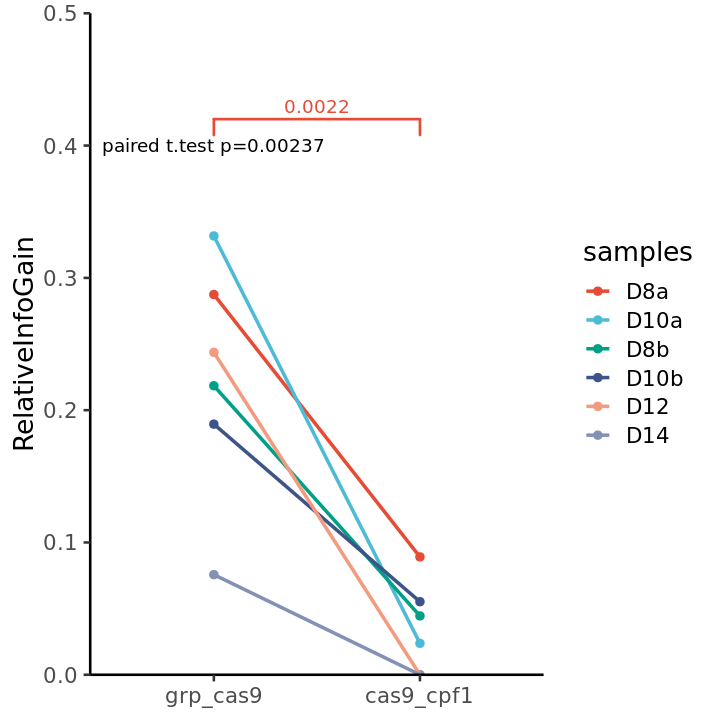

In [21]:
igs_long_test = igs_wide %>% select(samples, grp_cas9, cas9_cpf1) %>% pivot_longer(cols=c(grp_cas9, cas9_cpf1), names_to="levels", values_to="normalized_ig")
igs_long_test$levels = factor(igs_long_test$levels, levels=c("grp_cas9","cas9_cpf1"))
options(repr.plot.width=6, repr.plot.height=6)
compaired = list(c("grp_cas9","cas9_cpf1"))
ggplot(igs_long_test, aes(x=levels,y=normalized_ig, group=samples, color=samples))+
    #geom_jitter(aes(color=sample,fill=sample), width=0.1)+
    #geom_point(aes(color=sample,fill=sample), size=1)+
    geom_point(size=2)+
    geom_line("stat"="identity", size=1)+
    theme_classic(base_size = 16)+scale_color_npg()+scale_fill_npg()+
    geom_signif(comparisons = compaired, size=0.75, y_position = 0.4, test = 't.test')+
    labs(x=NULL,y='RelativeInfoGain')+scale_y_continuous(expand=c(0,0), limits=c(0,0.5))+
    annotate("text", x='grp_cas9', y=0.4, label="paired t.test p=0.00237")
ggsave("../results/Fig5_allsamples_cas9cpf1nmut_ig_level_comparison.pdf", width=6, height=6)